# Time Series Analysis and Forecasting with ARIMA Model

## Overview of Workflow

1. Prep data 
2. Test for stationarity 
3. if yes stationary, use grid search to find best forecast(p, d, q) values
4. if not stationary, transform data (log, double-log, differencing, moving avg...)
5. retest stationarity
6. if yes stationary, continue to forecasting
7. if not stationary, continue to transform until stationary
8. forecast
9. if data was transformed, do the inverse of the transformation
10. final forecast

## 1. Load data

In [36]:
import pandas as pd

data = pd.read_csv('../../data_sets/TimeSeries_TotalSolarGen_and_Load_IT_2016.csv')

In [37]:
data.head()

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


## 2. Visualize the data

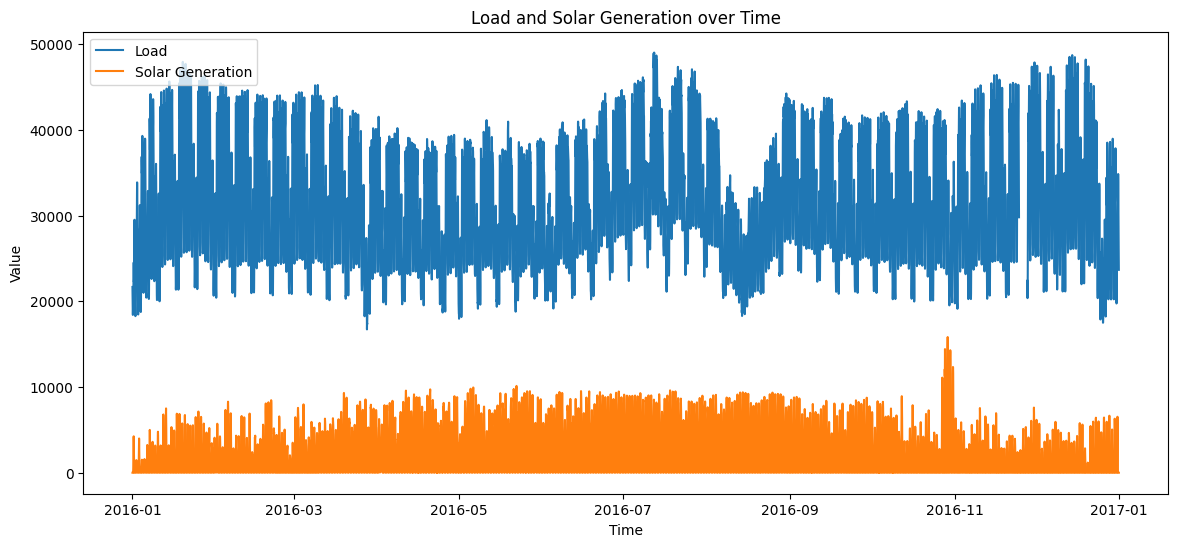

In [38]:
import matplotlib.pyplot as plt

# Convert utc_timestamp to datetime
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])

# Plot the data
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'], data['IT_load_new'], label='Load')
plt.plot(data['utc_timestamp'], data['IT_solar_generation'], label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Load and Solar Generation over Time')
plt.show()

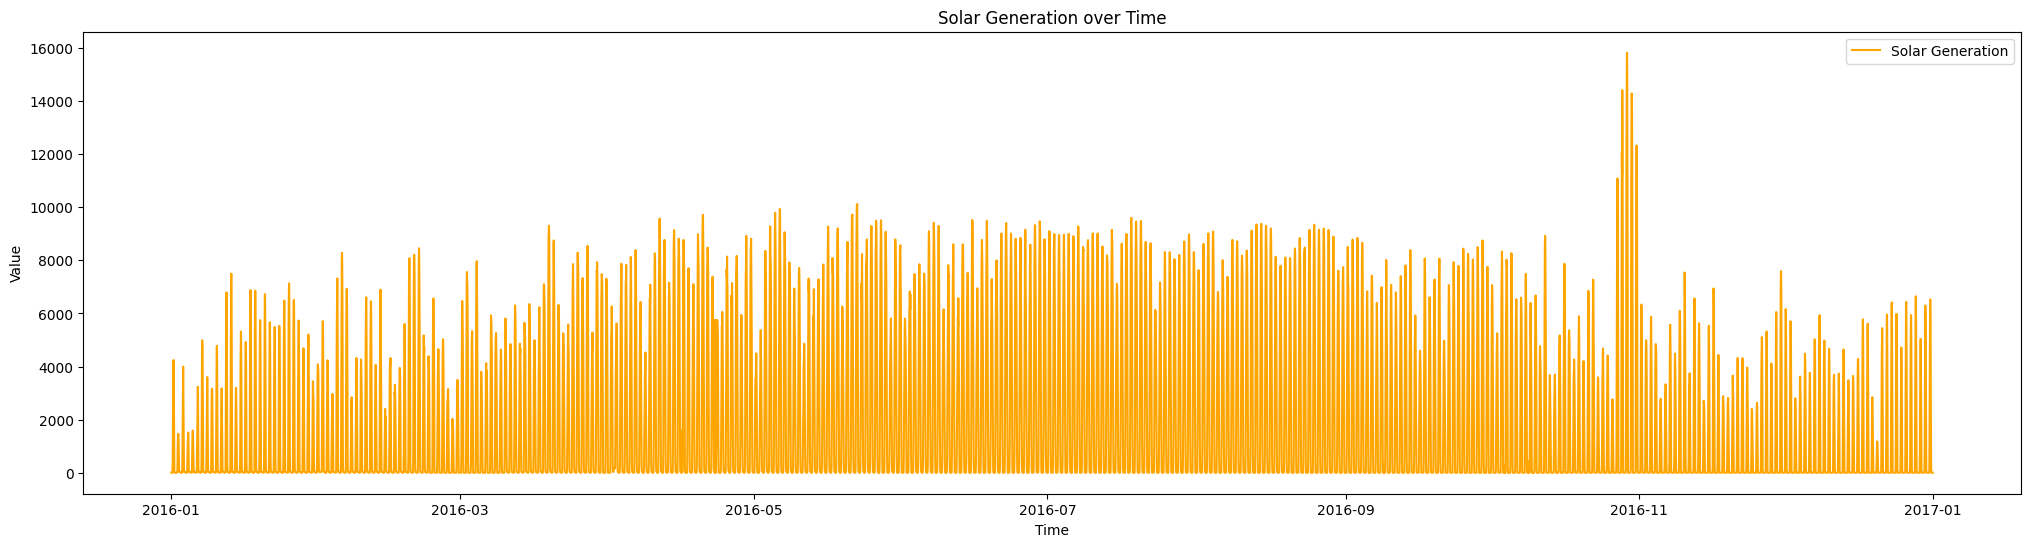

In [39]:
# This scale is not ideal for these two different plots.
# Plot the Solar Generation separately

plt.figure(figsize=(25,6))
# plt.plot(data['utc_timestamp'], data['IT_load_new'], label='Load')
plt.plot(
    data['utc_timestamp'], 
    data['IT_solar_generation'], 
    label='Solar Generation', 
    color='orange',
)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Solar Generation over Time')
plt.show()


This case demonstrates complexities of trend forecasting. Though there are easily visible patterns, there is no easily visible seasonality spikes. This does not mean there aren't any just because they aren't perceptible to the human eye.

The plot shows both the load and solar generation over time for the year 2016. The load appears to have a cyclical pattern with peaks and valleys, possibly corresponding to daily patterns of electrical use.

The solar generation also shows a clear pattern, with generation during the day and no generation at night (as expected). The amount of solar generation also appears to fluctuate throughout the year, likely due to seasonal changes in sunlight.

Before moving on to time series analysis and forecasting with ARIMA, it is importan to check for stationarity in time series data. Stationarity is a property of time series data that implies mean, variance, and autocorrelation structure do not change over time. Many time series models, including ARIMA, require the data to be stationary.

Perform the Augmented Dickey-Fuller test to check the stationarity of the time series. The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05), then you reject the null hypothesis and infer that the time series is indeed stationary.

## 3. Handle missing values

In [40]:
# check for missing values
data.isnull().sum()

utc_timestamp           0
IT_load_new            72
IT_solar_generation     0
dtype: int64

In [41]:
# Fill missing values using forward fill
data['IT_load_new'].fillna(method='ffill', inplace=True)

# Check again for missing values
data.isnull().sum()

/var/folders/nd/f27d3d4969v06hd_stq0_5680000gn/T/ipykernel_99424/3536692623.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['IT_load_new'].fillna(method='ffill', inplace=True)
/var/folders/nd/f27d3d4969v06hd_stq0_5680000gn/T/ipykernel_99424/3536692623.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['IT_load_new'].fillna(method='ffill', inplace=True)


utc_timestamp          0
IT_load_new            0
IT_solar_generation    0
dtype: int64

## Check for Stationarity

In [42]:
from statsmodels.tsa.stattools import adfuller

# Write Augmented Dickey-Fuller test function
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# Perform Augmented Dickey-Fuller test for IT Load
adf_test(data['IT_load_new'])

Results of Dickey-Fuller Test:
Test Statistic                -1.197390e+01
p-value                        3.841445e-22
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


In [43]:
# Perform Augmented Dickey-Fuller test for IT solar generation
adf_test(data['IT_solar_generation'])

Results of Dickey-Fuller Test:
Test Statistic                -5.741335e+00
p-value                        6.265438e-07
#Lags Used                     3.600000e+01
Number of Observations Used    8.747000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861870e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


**From the Augmented Dickey-Fuller test:**

For 'IT_load_new': the p-value is extremely low <0.05, so we reject the null hypothesis that the time series is non-stationary. Therefore, the 'IT_load_new' can be considered stationary.

For the 'IT_solar_generation': the p-value is also low < 0.05, so we reject the null hypothesis. This means 'IT_solar_generation' can be considered stationary as well.

Since both series are stationary, we can proceed with building an AutoRegressive Integrated Moving Average (ARIMA) model for each. ARIMA is a class of models that explain a given time series based on its own past values, that is, its own lags and the lagged forecast errors. The equation can be used for forecasting future values.

Any 'non-seasonal' time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: (p, d, q)

- p is the order of the AR term (number of lags of Y to be used as predictors).
- d is the number of differencing required to make the time series stationary.
    - in this case, since the series' are already staitonary, d=0 for both
- we need to determine the optimal values for p and q. To do this, we'll look at autocorrection function (ACF) and partial autocorrection function (PACF) plots.

## Build ARIMA model for 'IT_load_new'

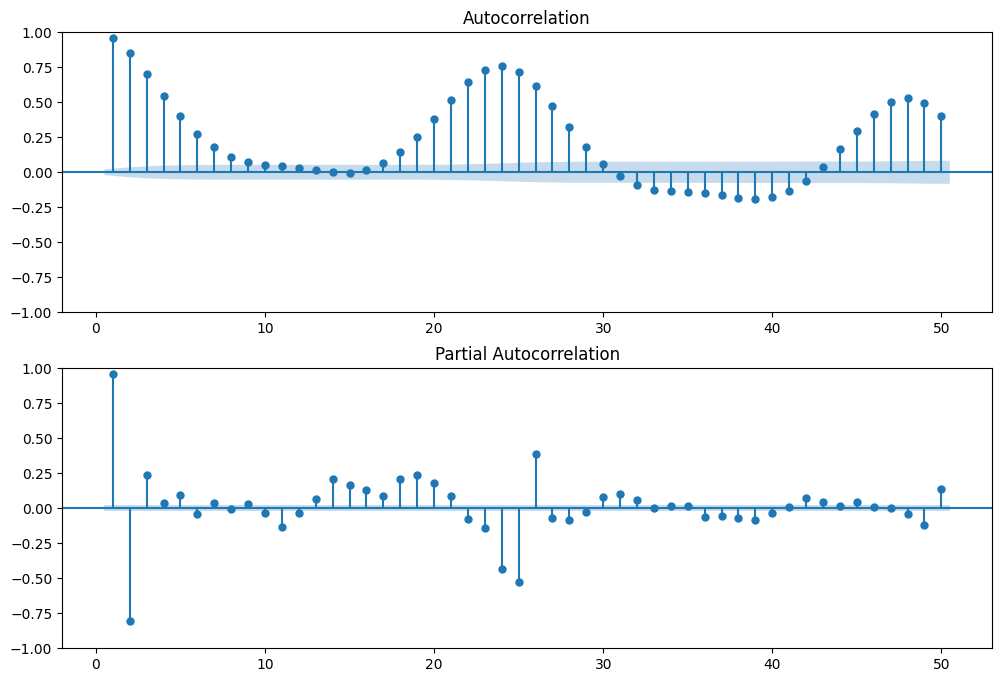

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot acf and pacf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(data['IT_load_new'], lags=50, zero=False, ax=ax1)
plot_pacf(data['IT_load_new'], lags=50, zero=False, ax=ax2)
plt.show()

**From the ACF plot, we see a gradual decrease, and from the PACF plot, there is a sharp drop after lag 2. So we can take p=2 and q=2 as our model parameters.**

Ideally you'd also do a Grid Search to find the optimal values. Fit the ARIMA model to 'IT_load_new' time series. Use an 80-20 train-test split.

In [47]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train-test split
series = data['IT_load_new']

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Store results
results = {}

# Test different d values
for d in [0, 1, 2]:
    model = ARIMA(train, order=(2, d, 2))
    model_fit = model.fit()
    
    predictions = model_fit.predict(
        start=len(train),
        end=len(train) + len(test) - 1
    )
    
    rmse = sqrt(mean_squared_error(test, predictions))
    results[d] = rmse
    
    print(f"d = {d} → RMSE: {rmse:.4f}")

print("\nBest d:", min(results, key=results.get))


d = 0 → RMSE: 7714.9521
d = 1 → RMSE: 7993.8494


/Users/stevesimonson/development/tutorials/PythonforDS/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/stevesimonson/development/tutorials/PythonforDS/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


d = 2 → RMSE: 9257.9832

Best d: 0


/Users/stevesimonson/development/tutorials/PythonforDS/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The root mean squared error (RMSE) for the ARIMA model on 'IT_load_new' is approximately 7115. RMSE is a measure of the differences between the values predicted by a modle and the values actually observed. It's a good measure of how accurately the model predicts the response, and it is the most important criterion for the fit if the main purpose of the model is prediction.

However, the values of the RMSE itself are not as informative as comparing it to some benchmark, like the standard deviation of the response, or comparing between different models for the same dataset.

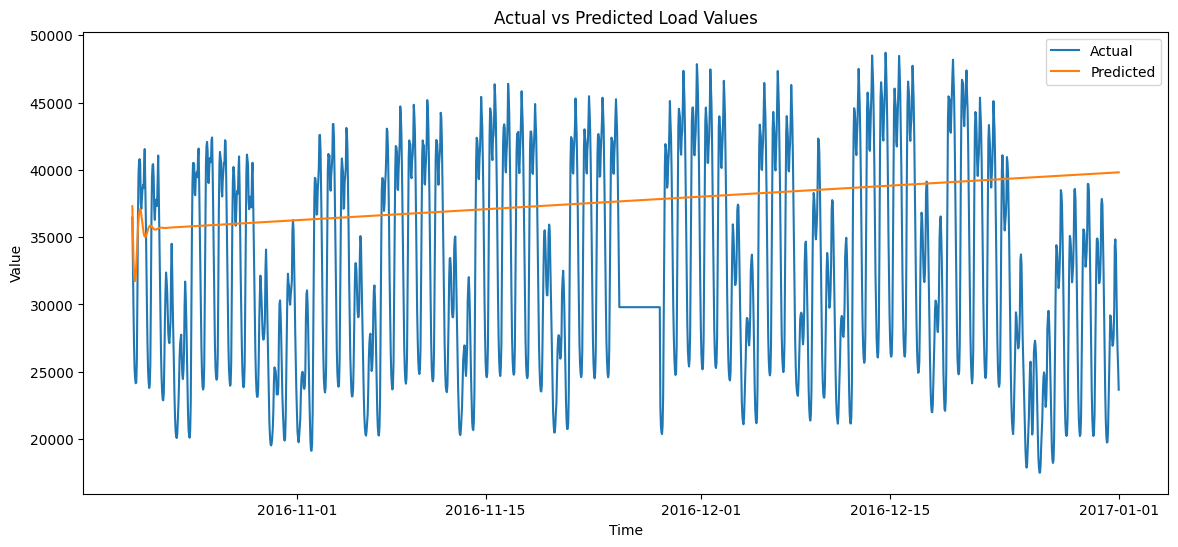

In [49]:
# Plot actual vs predicted values

plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()

This visualization shows ARIMA is not doing a good job predicting with this dataset. It accurately predicted a vague trend upward, but missed any volatility. This discrepancy could be due to various factors such as inherent randomness in the data, the presence of other unaccounted influence, or simply the limitations of the ARIMA model. More complex models or additional data preprocessing might improve the results.

Repeat the process for the 'IT_solar_generation' time series. Start by plotting the ACF and PACF to determine the parameters of the ARIMA model.

## Build ARIMA model for 'IT_solar_generation'

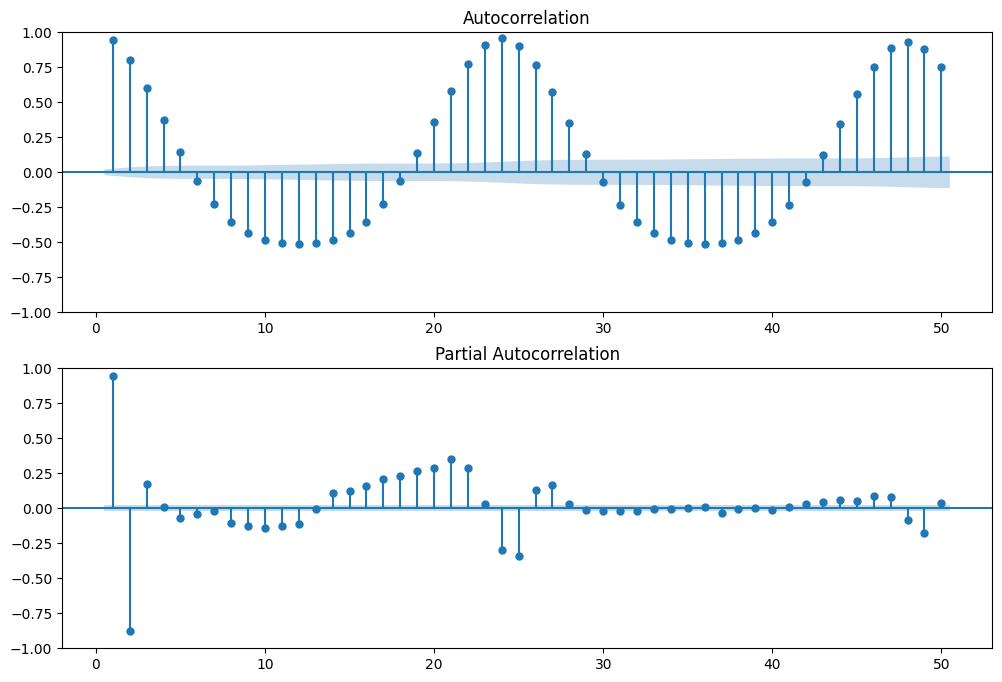

In [50]:
# Plot acf and pacf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(data['IT_solar_generation'], lags=50, zero=False, ax=ax1)
plot_pacf(data['IT_solar_generation'], lags=50, zero=False, ax=ax2)
plt.show()

In [51]:
# Train-test split
series = data['IT_solar_generation']

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Store results
results = {}

# Test different d values
for d in [0, 1, 2]:
    model = ARIMA(train, order=(2, d, 2))
    model_fit = model.fit()
    
    predictions = model_fit.predict(
        start=len(train),
        end=len(train) + len(test) - 1
    )
    
    rmse = sqrt(mean_squared_error(test, predictions))
    results[d] = rmse
    
    print(f"d = {d} → RMSE: {rmse:.4f}")

print("\nBest d:", min(results, key=results.get))

d = 0 → RMSE: 2486.1507
d = 1 → RMSE: 2364.5228
d = 2 → RMSE: 2397.9442

Best d: 1


The root mean square error (RMSE) for the ARIMA model on 'IT_solar_generation' is approximately 2486. As with the 'IT_load_new' model, this RMSE value can be used as a measure of how accurately the model predicts the response.

Again, it's beneficial to plot the actual values and the forecasted values to visualize how well our model is performing.

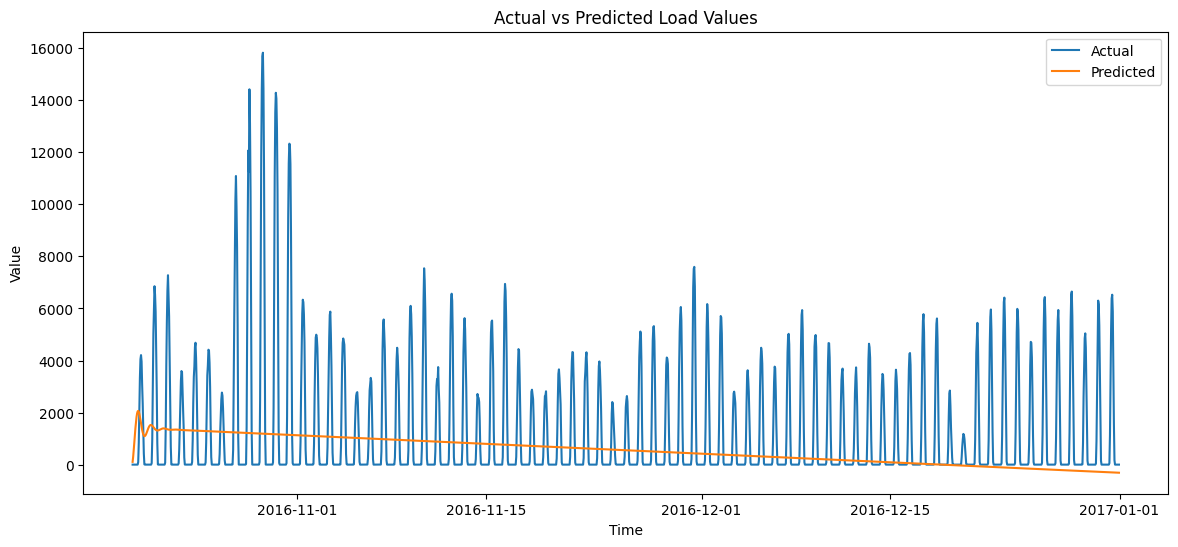

In [52]:
# Plot actual vs predicted values

plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()